Implementing AlexNet CNN Architecture

In [1]:
#Importing dependancies

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [2]:
#Creating Pre-Processing Pipeline
transform_train=transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224,padding =4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

transform_test=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

training_set=torchvision.datasets.CIFAR10(root=r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\datasets",train=True,download=True,transform=transform_train)  #Loads Dataset
train_loader=torch.utils.data.DataLoader(training_set,batch_size=64,shuffle=True)   #Wraps dataset and allows to load data in batches

testing_set=torchvision.datasets.CIFAR10(root=r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\datasets",train=False,download=True,transform=transform_test)
test_loader=torch.utils.data.DataLoader(testing_set,batch_size=64,shuffle=False)

alexnet=models.alexnet(pretrained=True)

#Freezing initial layers

for parameter in alexnet.features.parameters():
    parameter.requires_grad=False

#Replacing classifier to accomodate 10 classes of CIFAR10

alexnet.classifier=nn.Sequential(
    nn.Dropout(),
    nn.Linear(256*6*6,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Linear(512,10)
)

#Defining optimizers

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.001)

#Training the model

for epoch in range(5):
    alexnet.train()
    running_loss=0

    alexnet.to('cuda')

    for images,labels in train_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")









100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 169MB/s]


Epoch 1, Loss: 0.9335743013931357
Epoch 2, Loss: 0.7779478211613262
Epoch 3, Loss: 0.720968834750945
Epoch 4, Loss: 0.7038842206034819
Epoch 5, Loss: 0.6772571925235831


In [3]:
#Evaluating Model

correct=0
total=0

with torch.no_grad():
    for images,labels in test_loader:
        images= images.to('cuda')
        labels=labels.to('cuda')
        outputs=alexnet(images)

        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(f"Accuracy : {100*correct/total}%")




Accuracy : 76.97%


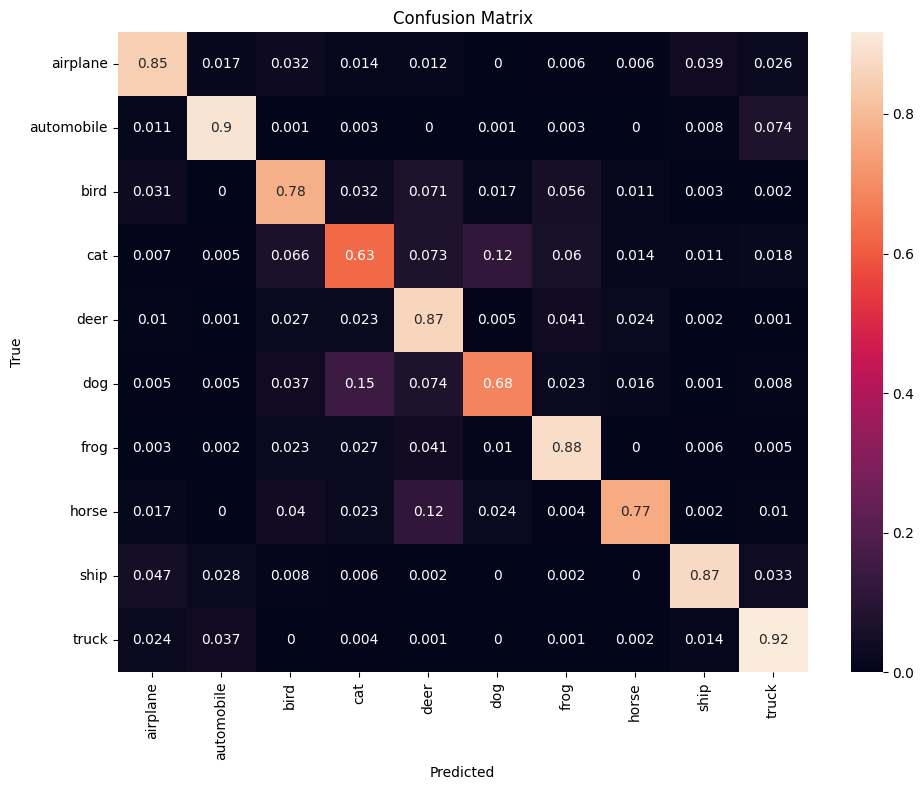

In [14]:
alexnet.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

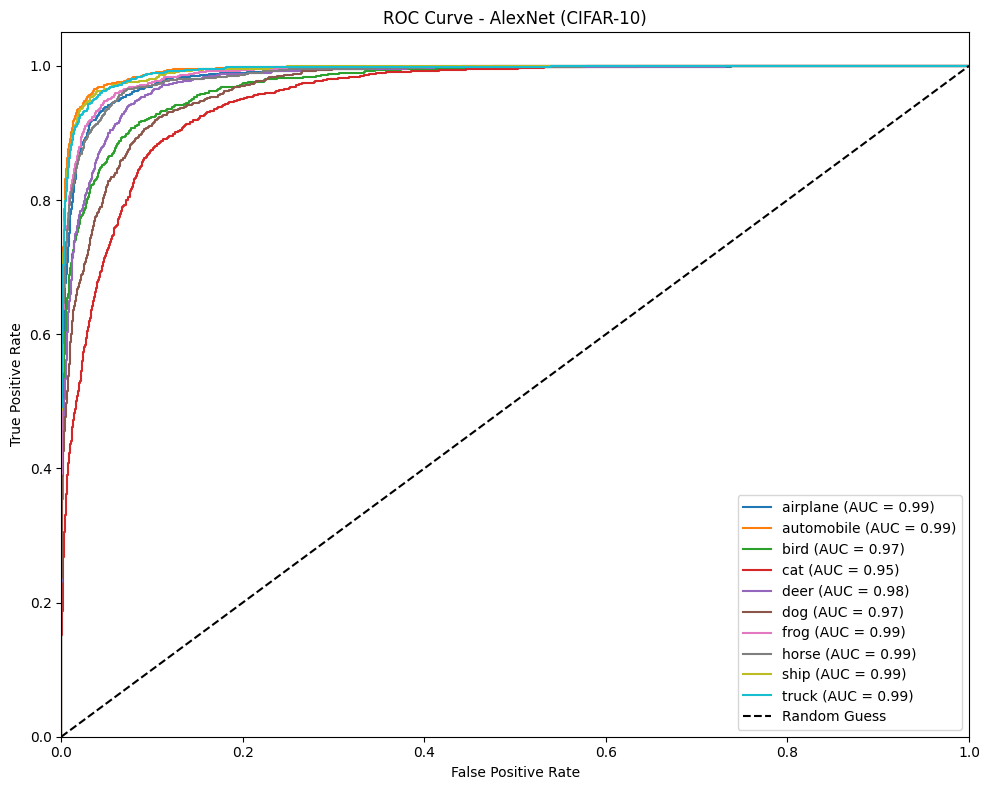

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# Class labels
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
n_classes = len(classes)

alexnet.eval()


all_labels = []
all_probs = []

# Collect predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = alexnet(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# C
y_score = np.array(all_probs)
y_true = label_binarize(all_labels, classes=list(range(n_classes)))  # One-hot encoding

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AlexNet (CIFAR-10)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Implementing ResNet150 CNN Architecture


In [4]:
resnet=models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

print(resnet)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:04<00:00, 56.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
for parameter in resnet.parameters():
    parameter.requires_grad=False

resnet.fc=nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

In [6]:
resnet = resnet.to('cuda')

loss_function_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

for epoch in range(2):
    resnet.train()
    running_loss_resnet = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        optimizer_resnet.zero_grad()
        outputs_resnet = resnet(images)
        loss = loss_function_resnet(outputs_resnet, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss_resnet += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs_resnet, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss_resnet / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:}, Accuracy: {epoch_accuracy:}%")


Epoch 1, Loss: 0.5842333175146671, Accuracy: 80.386%
Epoch 2, Loss: 0.48342993807838397, Accuracy: 83.624%


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

all_labels=[]
all_preds=[]
all_probs=[]

resnet.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels= images.to('cuda'), labels.to('cuda')

        outputs=resnet(images)
        probs=torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs,1)

        all_labels.extend(labels.cpu().numpy()) #To not get nested list
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report :\n", classification_report(all_labels, all_preds, target_names=classes))


Accuracy: 0.8629
Classification Report :
               precision    recall  f1-score   support

    airplane       0.82      0.91      0.87      1000
  automobile       0.95      0.88      0.91      1000
        bird       0.86      0.82      0.84      1000
         cat       0.75      0.80      0.78      1000
        deer       0.83      0.83      0.83      1000
         dog       0.89      0.80      0.84      1000
        frog       0.84      0.92      0.88      1000
       horse       0.91      0.84      0.87      1000
        ship       0.91      0.90      0.90      1000
       truck       0.89      0.92      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



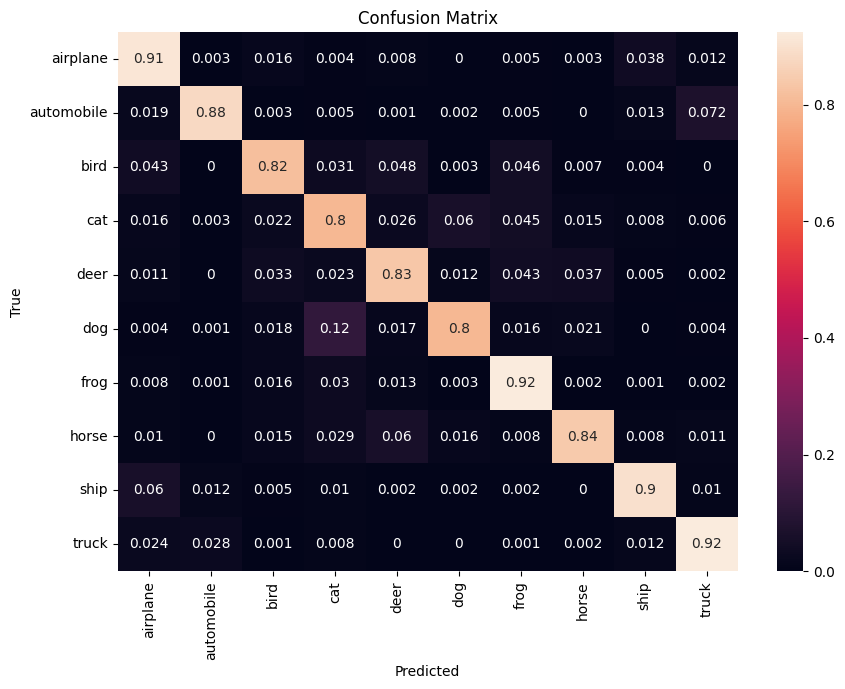

In [8]:
cm=confusion_matrix(all_labels,all_preds)
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

AUC for airplane: 0.99
AUC for automobile: 1.00
AUC for bird: 0.99
AUC for cat: 0.98
AUC for deer: 0.99
AUC for dog: 0.99
AUC for frog: 0.99
AUC for horse: 0.99
AUC for ship: 0.99
AUC for truck: 0.99
Macro-average AUC: 0.99


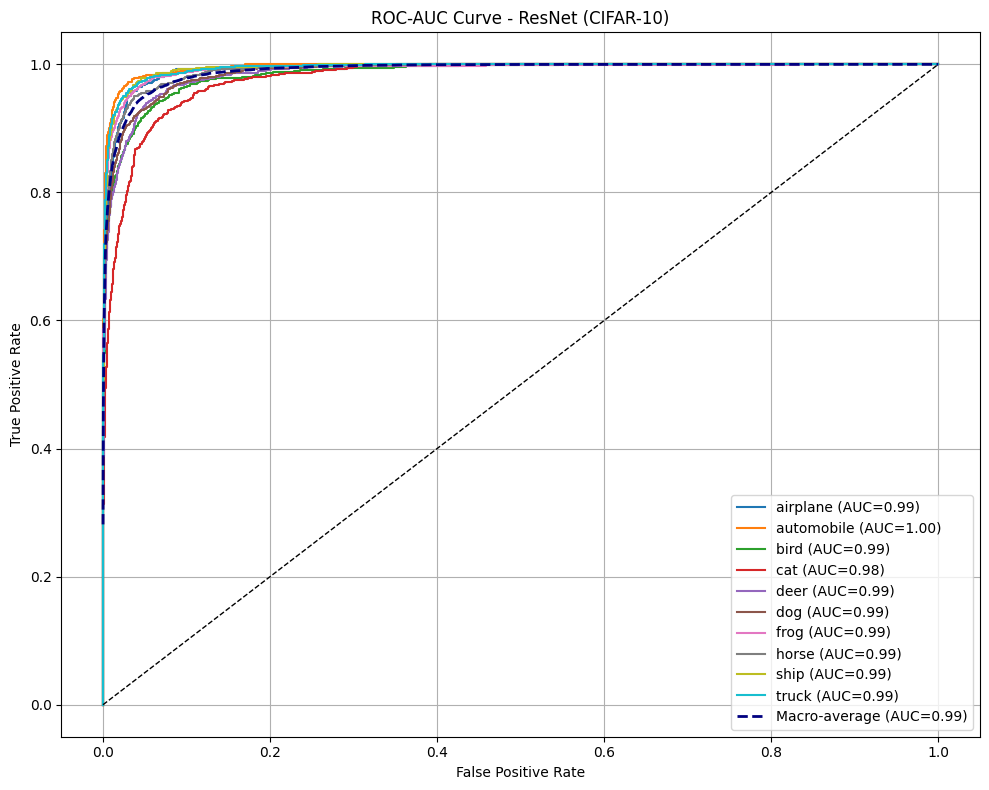

In [10]:
from sklearn.metrics import auc
resnet.eval()


y_true, y_score = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = resnet(images)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_score.extend(probs.cpu().numpy())


y_true = np.array(y_true)
y_score = np.array(y_score)


y_true_bin = label_binarize(y_true, classes=np.arange(10))


fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for {classes[i]}: {roc_auc[i]:.2f}")

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-average AUC: {roc_auc['macro']:.2f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
         label=f"Macro-average (AUC={roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve - ResNet (CIFAR-10)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
